# Unified XKCD Colors

A few years ago, Randall Munroe, the creator of the brilliant [XKCD](https://www.xkcd.com/) webcomic 
was sucked into the named color swamp. His adventures in the swamp are described in 
[this entertaining blog post](https://blog.xkcd.com/2010/05/03/color-survey-results/). The "product"
that emerged from his time in the swamp is a long list of "named colors." 

Named color lists are common. I used a list of 147 web colors for my Python `SmugPyter` [dominant image color program](https://github.com/bakerjd99/smugpyter). When putting together `SmugPyter` I wondered
if 147 colors were enough and if they were evenly distributed over the RGB color space.
I looked around for longer lists but didn't come up with anything until I stumbled on XKCD colors.

XKCD colors were derived for a crowdsourcing experiment. Munroe asked web volunteers to "name" colors
and then compiled the names. The result is both comprehensive and delightful. Some of the color names are:
"poo", "baby shit brown", "barney purple", "booger", "diarrhea", "milk chocolate", "shit brown", and "toxic green." 
I don't know about you but given a choice between a politically correct inoffensive color list like 
[CSS3](https://www.cssportal.com/css3-color-names/) that reads like it was composed by transgendered
EU bureaucrats on loan to the Canadian approved euphemism agency, and a manly up yours list that considers "diarrhea" a color
well, this mainly manly man knows which list he'll choose. 

However, before we dump [X11](https://www.w3schools.com/colors/colors_x11.asp), 
[CSS3](https://www.w3schools.com/cssref/css_colors.asp), [HTML4](https://www.w3schools.com/html/html_colors.asp) and other girly-man color lists we'll have to do a little hacking. 

### Let's cannibalize `webcolors.py`

Our hack begins by tearing apart some open source named color code. I want 
`SmugPyter` to use XKCD colors instead of standard lists so I am starting with
the Python module that `SmugPyter` imports to process named colors. I briefly considered
forking `webcolors.py`, making my changes, and then issuing a pull request to have
XKCD colors added as an official part of `webcolors.py` but that sounds like work and
this is for fun. Besides, in every large program there's a small program screaming to get out.
Let's just grab the germane bits of `webcolors.py` and XKCD'ify.

From my poking around the following parts of `webcolors.py` are need to process XKCD colors.

In [1]:
# XKCD color handling
import collections
import re
from math import sqrt

# tests and displays
import numpy as np
from PIL import Image
import random

# kmeans clustering
import scipy
import scipy.misc
import scipy.cluster
from sklearn.cluster import KMeans

# paths & files
import glob
import os
import csv

# call J from python
import jbase as j 
print(j.__doc__)


usage:
 jbase.init(True)  # True (default) loads profile - False avoids
 
 jbase.dor('i.2 3 4')    # run sentence and print output result
 jbase.do(('+a.')        # run and return error code
 jbase.getr()            # get last output result
 jbase.do('abc=: i.2 3') # define abc
 q= jbase.get('abc')     # get q as numpy array from J array 
 jbase.set('ghi',23+q)   # set J array from numpy array
 jbase.dor('ghi')        # print array 
 jbase.j()               # J repl - .... to exit

types:
 python types supported: strings, bytes, numpy int64/float64 
 numpy arrays have shape
 json covers some other requirements
 
Developed with Python 3.6.4 (Anaconda) and J807.

Works with python kernel in Jupyter.




In [2]:
# NOTE: the code in this cell has been modified from the original source: 
# https://github.com/ubernostrum/webcolors

HEX_COLOR_RE = re.compile(r'^#([a-fA-F0-9]{3}|[a-fA-F0-9]{6})$')

IntegerRGB = collections.namedtuple('IntegerRGB', ['red', 'green', 'blue'])

def _normalize_integer_rgb(value):
    """
    Internal normalization function for clipping integer values into
    the permitted range (0-255, inclusive).
    """
    return 0 if value < 0 \
        else 255 if value > 255 \
        else value

def normalize_integer_triplet(rgb_triplet):
    """
    Normalize an integer ``rgb()`` triplet so that all values are
    within the range 0-255 inclusive.
    """
    return IntegerRGB._make(
        _normalize_integer_rgb(value) for value in rgb_triplet
    )

def _reversedict(d):
    """
    Internal helper for generating reverse mappings; given a
    dictionary, returns a new dictionary with keys and values swapped.
    """
    return {value: key for key, value in d.items()}

def normalize_hex(hex_value):
    """
    Normalize a hexadecimal color value to 6 digits, lowercase.
    """
    match = HEX_COLOR_RE.match(hex_value)
    if match is None:
        raise ValueError(
            u"'{}' is not a valid hexadecimal color value.".format(hex_value)
        )
    hex_digits = match.group(1)
    if len(hex_digits) == 3:
        hex_digits = u''.join(2 * s for s in hex_digits)
    return u'#{}'.format(hex_digits.lower())

def hex_to_rgb(hex_value):
    """
    Convert a hexadecimal color value to a 3-tuple of integers
    suitable for use in an ``rgb()`` triplet specifying that color.
    """
    hex_value = normalize_hex(hex_value)
    hex_value = int(hex_value[1:], 16)
    return IntegerRGB(
        hex_value >> 16,
        hex_value >> 8 & 0xff,
        hex_value & 0xff
    )

def normalize_integer_triplet(rgb_triplet):
    """
    Normalize an integer ``rgb()`` triplet so that all values are
    within the range 0-255 inclusive.
    """
    return IntegerRGB._make(
        _normalize_integer_rgb(value) for value in rgb_triplet
    )

def hex_to_name(hex_value):
    """
    Convert a hexadecimal color value to its corresponding normalized
    color name, if any such name exists.
    
    When no color name for the value is found the result is None.
    """
    normalized = normalize_hex(hex_value)
    name = XKCD_HEX_TO_NAMES.get(normalized)
    return name

def rgb_to_hex(rgb_triplet):
    """
    Convert a 3-tuple of integers, suitable for use in an ``rgb()``
    color triplet, to a normalized hexadecimal value for that color.
    """
    return u'#{:02x}{:02x}{:02x}'.format(
        *normalize_integer_triplet(
            rgb_triplet
        )
    )

def rgb_to_name(rgb_triplet):
    """
    Convert a 3-tuple of integers, suitable for use in an ``rgb()``
    color triplet, to its corresponding normalized color name, if any
    such name exists.

    If there is no matching name None is returned
    """
    return hex_to_name(
        rgb_to_hex(
            normalize_integer_triplet(
                rgb_triplet
            )
        )
    )

### Unified XKCD Color Dictionary

`webcolors.py` also contains long Python dictionary definitions that map names to colors coded as hexidecimals.

In [3]:
CSS3_NAMES_TO_HEX = {
    u'aliceblue': u'#f0f8ff',
    u'antiquewhite': u'#faebd7',
    u'aqua': u'#00ffff',
    u'aquamarine': u'#7fffd4',
    u'azure': u'#f0ffff',
    u'beige': u'#f5f5dc',
    u'bisque': u'#ffe4c4',
    u'black': u'#000000',
    u'blanchedalmond': u'#ffebcd',
    u'blue': u'#0000ff',
    u'blueviolet': u'#8a2be2',
    u'brown': u'#a52a2a',
    u'burlywood': u'#deb887',
    u'cadetblue': u'#5f9ea0',
    u'chartreuse': u'#7fff00',
    u'chocolate': u'#d2691e',
    u'coral': u'#ff7f50',
    u'cornflowerblue': u'#6495ed',
    u'cornsilk': u'#fff8dc',
    u'crimson': u'#dc143c',
    u'cyan': u'#00ffff',
    u'darkblue': u'#00008b',
    u'darkcyan': u'#008b8b',
    u'darkgoldenrod': u'#b8860b',
    u'darkgray': u'#a9a9a9',
    u'darkgrey': u'#a9a9a9',
    u'darkgreen': u'#006400',
    u'darkkhaki': u'#bdb76b',
    u'darkmagenta': u'#8b008b',
    u'darkolivegreen': u'#556b2f',
    u'darkorange': u'#ff8c00',
    u'darkorchid': u'#9932cc',
    u'darkred': u'#8b0000',
    u'darksalmon': u'#e9967a',
    u'darkseagreen': u'#8fbc8f',
    u'darkslateblue': u'#483d8b',
    u'darkslategray': u'#2f4f4f',
    u'darkslategrey': u'#2f4f4f',
    u'darkturquoise': u'#00ced1',
    u'darkviolet': u'#9400d3',
    u'deeppink': u'#ff1493',
    u'deepskyblue': u'#00bfff',
    u'dimgray': u'#696969',
    u'dimgrey': u'#696969',
    u'dodgerblue': u'#1e90ff',
    u'firebrick': u'#b22222',
    u'floralwhite': u'#fffaf0',
    u'forestgreen': u'#228b22',
    u'fuchsia': u'#ff00ff',
    u'gainsboro': u'#dcdcdc',
    u'ghostwhite': u'#f8f8ff',
    u'gold': u'#ffd700',
    u'goldenrod': u'#daa520',
    u'gray': u'#808080',
    u'grey': u'#808080',
    u'green': u'#008000',
    u'greenyellow': u'#adff2f',
    u'honeydew': u'#f0fff0',
    u'hotpink': u'#ff69b4',
    u'indianred': u'#cd5c5c',
    u'indigo': u'#4b0082',
    u'ivory': u'#fffff0',
    u'khaki': u'#f0e68c',
    u'lavender': u'#e6e6fa',
    u'lavenderblush': u'#fff0f5',
    u'lawngreen': u'#7cfc00',
    u'lemonchiffon': u'#fffacd',
    u'lightblue': u'#add8e6',
    u'lightcoral': u'#f08080',
    u'lightcyan': u'#e0ffff',
    u'lightgoldenrodyellow': u'#fafad2',
    u'lightgray': u'#d3d3d3',
    u'lightgrey': u'#d3d3d3',
    u'lightgreen': u'#90ee90',
    u'lightpink': u'#ffb6c1',
    u'lightsalmon': u'#ffa07a',
    u'lightseagreen': u'#20b2aa',
    u'lightskyblue': u'#87cefa',
    u'lightslategray': u'#778899',
    u'lightslategrey': u'#778899',
    u'lightsteelblue': u'#b0c4de',
    u'lightyellow': u'#ffffe0',
    u'lime': u'#00ff00',
    u'limegreen': u'#32cd32',
    u'linen': u'#faf0e6',
    u'magenta': u'#ff00ff',
    u'maroon': u'#800000',
    u'mediumaquamarine': u'#66cdaa',
    u'mediumblue': u'#0000cd',
    u'mediumorchid': u'#ba55d3',
    u'mediumpurple': u'#9370db',
    u'mediumseagreen': u'#3cb371',
    u'mediumslateblue': u'#7b68ee',
    u'mediumspringgreen': u'#00fa9a',
    u'mediumturquoise': u'#48d1cc',
    u'mediumvioletred': u'#c71585',
    u'midnightblue': u'#191970',
    u'mintcream': u'#f5fffa',
    u'mistyrose': u'#ffe4e1',
    u'moccasin': u'#ffe4b5',
    u'navajowhite': u'#ffdead',
    u'navy': u'#000080',
    u'oldlace': u'#fdf5e6',
    u'olive': u'#808000',
    u'olivedrab': u'#6b8e23',
    u'orange': u'#ffa500',
    u'orangered': u'#ff4500',
    u'orchid': u'#da70d6',
    u'palegoldenrod': u'#eee8aa',
    u'palegreen': u'#98fb98',
    u'paleturquoise': u'#afeeee',
    u'palevioletred': u'#db7093',
    u'papayawhip': u'#ffefd5',
    u'peachpuff': u'#ffdab9',
    u'peru': u'#cd853f',
    u'pink': u'#ffc0cb',
    u'plum': u'#dda0dd',
    u'powderblue': u'#b0e0e6',
    u'purple': u'#800080',
    u'red': u'#ff0000',
    u'rosybrown': u'#bc8f8f',
    u'royalblue': u'#4169e1',
    u'saddlebrown': u'#8b4513',
    u'salmon': u'#fa8072',
    u'sandybrown': u'#f4a460',
    u'seagreen': u'#2e8b57',
    u'seashell': u'#fff5ee',
    u'sienna': u'#a0522d',
    u'silver': u'#c0c0c0',
    u'skyblue': u'#87ceeb',
    u'slateblue': u'#6a5acd',
    u'slategray': u'#708090',
    u'slategrey': u'#708090',
    u'snow': u'#fffafa',
    u'springgreen': u'#00ff7f',
    u'steelblue': u'#4682b4',
    u'tan': u'#d2b48c',
    u'teal': u'#008080',
    u'thistle': u'#d8bfd8',
    u'tomato': u'#ff6347',
    u'turquoise': u'#40e0d0',
    u'violet': u'#ee82ee',
    u'wheat': u'#f5deb3',
    u'white': u'#ffffff',
    u'whitesmoke': u'#f5f5f5',
    u'yellow': u'#ffff00',
    u'yellowgreen': u'#9acd32',
}

# reverse dictionary
CSS3_HEX_TO_NAMES = _reversedict(CSS3_NAMES_TO_HEX)
len(CSS3_HEX_TO_NAMES)

138

To use XKCD colors add a similiar dictionary. The following defines what I call
 **Unified XKCD Colors.**.  It was derived by merging `webcolors`, `CSS3` colors
 and XKCD colors. I removed duplicate names and duplicate codes. The result is
 a list of 970 uniquely named colors.

In [4]:
# License: http://creativecommons.org/publicdomain/zero/1.0/
XKCD_NAMES_TO_HEX = {
    u'acidgreen': u'#8ffe09',
    u'adobe': u'#bd6c48',
    u'algae': u'#54ac68',
    u'algaegreen': u'#21c36f',
    u'aliceblue': u'#f0f8ff',
    u'almostblack': u'#070d0d',
    u'amber': u'#feb308',
    u'amethyst': u'#9b5fc0',
    u'antiquewhite': u'#faebd7',
    u'apple': u'#6ecb3c',
    u'applegreen': u'#76cd26',
    u'apricot': u'#ffb16d',
    u'aqua': u'#00ffff',
    u'aquablue': u'#02d8e9',
    u'aquagreen': u'#12e193',
    u'aquamarine': u'#7fffd4',
    u'armygreen': u'#4b5d16',
    u'asparagus': u'#77ab56',
    u'aubergine': u'#3d0734',
    u'auburn': u'#9a3001',
    u'avocado': u'#90b134',
    u'avocadogreen': u'#87a922',
    u'azul': u'#1d5dec',
    u'azure': u'#f0ffff',
    u'babyblue': u'#a2cffe',
    u'babygreen': u'#8cff9e',
    u'babypink': u'#ffb7ce',
    u'babypoo': u'#ab9004',
    u'babypoop': u'#937c00',
    u'babypoopgreen': u'#8f9805',
    u'babypukegreen': u'#b6c406',
    u'babypurple': u'#ca9bf7',
    u'babyshitbrown': u'#ad900d',
    u'babyshitgreen': u'#889717',
    u'banana': u'#ffff7e',
    u'bananayellow': u'#fafe4b',
    u'barbiepink': u'#fe46a5',
    u'barfgreen': u'#94ac02',
    u'barney': u'#ac1db8',
    u'barneypurple': u'#a00498',
    u'battleshipgrey': u'#6b7c85',
    u'beige': u'#f5f5dc',
    u'berry': u'#990f4b',
    u'bile': u'#b5c306',
    u'bisque': u'#ffe4c4',
    u'black': u'#000000',
    u'blanchedalmond': u'#ffebcd',
    u'bland': u'#afa88b',
    u'blood': u'#770001',
    u'bloodorange': u'#fe4b03',
    u'bloodred': u'#980002',
    u'blue': u'#0000ff',
    u'blueberry': u'#464196',
    u'blueblue': u'#2242c7',
    u'bluegreen': u'#017a79',
    u'bluegrey': u'#607c8e',
    u'bluepurple': u'#5729ce',
    u'blueviolet': u'#8a2be2',
    u'bluewithahintofpurple': u'#533cc6',
    u'blueygreen': u'#2bb179',
    u'blueygrey': u'#89a0b0',
    u'blueypurple': u'#6241c7',
    u'bluish': u'#2976bb',
    u'bluishgreen': u'#10a674',
    u'bluishgrey': u'#748b97',
    u'bluishpurple': u'#703be7',
    u'blurple': u'#5539cc',
    u'blush': u'#f29e8e',
    u'blushpink': u'#fe828c',
    u'booger': u'#9bb53c',
    u'boogergreen': u'#96b403',
    u'bordeaux': u'#7b002c',
    u'boringgreen': u'#63b365',
    u'bottlegreen': u'#044a05',
    u'brick': u'#a03623',
    u'brickorange': u'#c14a09',
    u'brickred': u'#8f1402',
    u'brightaqua': u'#0bf9ea',
    u'brightblue': u'#0165fc',
    u'brightcyan': u'#41fdfe',
    u'brightgreen': u'#01ff07',
    u'brightlavender': u'#c760ff',
    u'brightlightblue': u'#26f7fd',
    u'brightlightgreen': u'#2dfe54',
    u'brightlilac': u'#c95efb',
    u'brightlime': u'#87fd05',
    u'brightlimegreen': u'#65fe08',
    u'brightmagenta': u'#ff08e8',
    u'brightolive': u'#9cbb04',
    u'brightorange': u'#ff5b00',
    u'brightpink': u'#fe01b1',
    u'brightpurple': u'#be03fd',
    u'brightred': u'#ff000d',
    u'brightseagreen': u'#05ffa6',
    u'brightskyblue': u'#02ccfe',
    u'brightteal': u'#01f9c6',
    u'brightturquoise': u'#0ffef9',
    u'brightviolet': u'#ad0afd',
    u'brightyellow': u'#fffd01',
    u'brightyellowgreen': u'#9dff00',
    u'britishracinggreen': u'#05480d',
    u'bronze': u'#a87900',
    u'brown': u'#a52a2a',
    u'browngreen': u'#706c11',
    u'browngrey': u'#8d8468',
    u'brownish': u'#9c6d57',
    u'brownishgreen': u'#6a6e09',
    u'brownishgrey': u'#86775f',
    u'brownishorange': u'#cb7723',
    u'brownishpink': u'#c27e79',
    u'brownishpurple': u'#76424e',
    u'brownishred': u'#9e3623',
    u'brownishyellow': u'#c9b003',
    u'brownorange': u'#b96902',
    u'brownred': u'#922b05',
    u'brownyellow': u'#b29705',
    u'brownygreen': u'#6f6c0a',
    u'brownyorange': u'#ca6b02',
    u'bruise': u'#7e4071',
    u'bubblegum': u'#ff6cb5',
    u'bubblegumpink': u'#fe83cc',
    u'buff': u'#fef69e',
    u'burgundy': u'#610023',
    u'burlywood': u'#deb887',
    u'burntorange': u'#c04e01',
    u'burntred': u'#9f2305',
    u'burntsiena': u'#b75203',
    u'burntsienna': u'#b04e0f',
    u'burntumber': u'#a0450e',
    u'burntyellow': u'#d5ab09',
    u'burple': u'#6832e3',
    u'butter': u'#ffff81',
    u'butterscotch': u'#fdb147',
    u'butteryellow': u'#fffd74',
    u'cadetblue': u'#5f9ea0',
    u'camel': u'#c69f59',
    u'camo': u'#7f8f4e',
    u'camogreen': u'#526525',
    u'camouflagegreen': u'#4b6113',
    u'canary': u'#fdff63',
    u'canaryyellow': u'#fffe40',
    u'candypink': u'#ff63e9',
    u'caramel': u'#af6f09',
    u'carmine': u'#9d0216',
    u'carnation': u'#fd798f',
    u'carnationpink': u'#ff7fa7',
    u'carolinablue': u'#8ab8fe',
    u'celadon': u'#befdb7',
    u'celery': u'#c1fd95',
    u'cement': u'#a5a391',
    u'cerise': u'#de0c62',
    u'cerulean': u'#0485d1',
    u'ceruleanblue': u'#056eee',
    u'charcoal': u'#343837',
    u'charcoalgrey': u'#3c4142',
    u'chartreuse': u'#7fff00',
    u'cherry': u'#cf0234',
    u'cherryred': u'#f7022a',
    u'chestnut': u'#742802',
    u'chocolate': u'#d2691e',
    u'chocolatebrown': u'#411900',
    u'cinnamon': u'#ac4f06',
    u'claret': u'#680018',
    u'clay': u'#b66a50',
    u'claybrown': u'#b2713d',
    u'clearblue': u'#247afd',
    u'cloudyblue': u'#acc2d9',
    u'cobalt': u'#1e488f',
    u'cobaltblue': u'#030aa7',
    u'cocoa': u'#875f42',
    u'coffee': u'#a6814c',
    u'coolblue': u'#4984b8',
    u'coolgreen': u'#33b864',
    u'coolgrey': u'#95a3a6',
    u'copper': u'#b66325',
    u'coral': u'#ff7f50',
    u'coralpink': u'#ff6163',
    u'cornflower': u'#6a79f7',
    u'cornflowerblue': u'#6495ed',
    u'cornsilk': u'#fff8dc',
    u'cranberry': u'#9e003a',
    u'cream': u'#ffffc2',
    u'creme': u'#ffffb6',
    u'crimson': u'#dc143c',
    u'custard': u'#fffd78',
    u'dandelion': u'#fedf08',
    u'dark': u'#1b2431',
    u'darkaqua': u'#05696b',
    u'darkaquamarine': u'#017371',
    u'darkbeige': u'#ac9362',
    u'darkblue': u'#00008b',
    u'darkbluegreen': u'#005249',
    u'darkbluegrey': u'#1f3b4d',
    u'darkbrown': u'#341c02',
    u'darkcoral': u'#cf524e',
    u'darkcream': u'#fff39a',
    u'darkcyan': u'#008b8b',
    u'darkforestgreen': u'#002d04',
    u'darkfuchsia': u'#9d0759',
    u'darkgold': u'#b59410',
    u'darkgoldenrod': u'#b8860b',
    u'darkgrassgreen': u'#388004',
    u'darkgray': u'#a9a9a9',
    u'darkgreen': u'#006400',
    u'darkgreenblue': u'#1f6357',
    u'darkgrey': u'#363737',
    u'darkgreyblue': u'#29465b',
    u'darkhotpink': u'#d90166',
    u'darkindigo': u'#1f0954',
    u'darkishblue': u'#014182',
    u'darkishgreen': u'#287c37',
    u'darkishpink': u'#da467d',
    u'darkishpurple': u'#751973',
    u'darkishred': u'#a90308',
    u'darkkhaki': u'#bdb76b',
    u'darklavender': u'#856798',
    u'darklilac': u'#9c6da5',
    u'darklime': u'#84b701',
    u'darklimegreen': u'#7ebd01',
    u'darkmagenta': u'#8b008b',
    u'darkmaroon': u'#3c0008',
    u'darkmauve': u'#874c62',
    u'darkmint': u'#48c072',
    u'darkmintgreen': u'#20c073',
    u'darkmustard': u'#a88905',
    u'darknavy': u'#000435',
    u'darknavyblue': u'#00022e',
    u'darkolive': u'#373e02',
    u'darkolivegreen': u'#556b2f',
    u'darkorange': u'#ff8c00',
    u'darkorchid': u'#9932cc',
    u'darkpastelgreen': u'#56ae57',
    u'darkpeach': u'#de7e5d',
    u'darkperiwinkle': u'#665fd1',
    u'darkpink': u'#cb416b',
    u'darkplum': u'#3f012c',
    u'darkpurple': u'#35063e',
    u'darkred': u'#8b0000',
    u'darkrose': u'#b5485d',
    u'darkroyalblue': u'#02066f',
    u'darksage': u'#598556',
    u'darksalmon': u'#e9967a',
    u'darksand': u'#a88f59',
    u'darkseafoam': u'#1fb57a',
    u'darkseafoamgreen': u'#3eaf76',
    u'darkseagreen': u'#8fbc8f',
    u'darkskyblue': u'#448ee4',
    u'darkslateblue': u'#483d8b',
    u'darkslategray': u'#2f4f4f',
    u'darktan': u'#af884a',
    u'darktaupe': u'#7f684e',
    u'darkteal': u'#014d4e',
    u'darkturquoise': u'#00ced1',
    u'darkviolet': u'#9400d3',
    u'darkyellow': u'#d5b60a',
    u'darkyellowgreen': u'#728f02',
    u'deepaqua': u'#08787f',
    u'deepblue': u'#040273',
    u'deepbrown': u'#410200',
    u'deepgreen': u'#02590f',
    u'deeplavender': u'#8d5eb7',
    u'deeplilac': u'#966ebd',
    u'deepmagenta': u'#a0025c',
    u'deeporange': u'#dc4d01',
    u'deeppink': u'#ff1493',
    u'deeppurple': u'#36013f',
    u'deepred': u'#9a0200',
    u'deeprose': u'#c74767',
    u'deepseablue': u'#015482',
    u'deepskyblue': u'#00bfff',
    u'deepteal': u'#00555a',
    u'deepturquoise': u'#017374',
    u'deepviolet': u'#490648',
    u'denim': u'#3b638c',
    u'denimblue': u'#3b5b92',
    u'desert': u'#ccad60',
    u'diarrhea': u'#9f8303',
    u'dimgray': u'#696969',
    u'dirt': u'#8a6e45',
    u'dirtbrown': u'#836539',
    u'dirtyblue': u'#3f829d',
    u'dirtygreen': u'#667e2c',
    u'dirtyorange': u'#c87606',
    u'dirtypink': u'#ca7b80',
    u'dirtypurple': u'#734a65',
    u'dirtyyellow': u'#cdc50a',
    u'dodgerblue': u'#1e90ff',
    u'drab': u'#828344',
    u'drabgreen': u'#749551',
    u'driedblood': u'#4b0101',
    u'duckeggblue': u'#c3fbf4',
    u'dullblue': u'#49759c',
    u'dullbrown': u'#876e4b',
    u'dullgreen': u'#74a662',
    u'dullorange': u'#d8863b',
    u'dullpink': u'#d5869d',
    u'dullpurple': u'#84597e',
    u'dullred': u'#bb3f3f',
    u'dullteal': u'#5f9e8f',
    u'dullyellow': u'#eedc5b',
    u'dusk': u'#4e5481',
    u'duskblue': u'#26538d',
    u'duskyblue': u'#475f94',
    u'duskypink': u'#cc7a8b',
    u'duskypurple': u'#895b7b',
    u'duskyrose': u'#ba6873',
    u'dust': u'#b2996e',
    u'dustyblue': u'#5a86ad',
    u'dustygreen': u'#76a973',
    u'dustylavender': u'#ac86a8',
    u'dustyorange': u'#f0833a',
    u'dustypink': u'#d58a94',
    u'dustypurple': u'#825f87',
    u'dustyred': u'#b9484e',
    u'dustyrose': u'#c0737a',
    u'dustyteal': u'#4c9085',
    u'earth': u'#a2653e',
    u'eastergreen': u'#8cfd7e',
    u'easterpurple': u'#c071fe',
    u'ecru': u'#feffca',
    u'eggplant': u'#380835',
    u'eggplantpurple': u'#430541',
    u'eggshell': u'#fffcc4',
    u'eggshellblue': u'#c4fff7',
    u'electricblue': u'#0652ff',
    u'electricgreen': u'#21fc0d',
    u'electriclime': u'#a8ff04',
    u'electricpink': u'#ff0490',
    u'electricpurple': u'#aa23ff',
    u'emerald': u'#01a049',
    u'emeraldgreen': u'#028f1e',
    u'evergreen': u'#05472a',
    u'fadedblue': u'#658cbb',
    u'fadedgreen': u'#7bb274',
    u'fadedorange': u'#f0944d',
    u'fadedpink': u'#de9dac',
    u'fadedpurple': u'#916e99',
    u'fadedred': u'#d3494e',
    u'fadedyellow': u'#feff7f',
    u'fawn': u'#cfaf7b',
    u'fern': u'#63a950',
    u'ferngreen': u'#548d44',
    u'firebrick': u'#b22222',
    u'fireenginered': u'#fe0002',
    u'flatblue': u'#3c73a8',
    u'flatgreen': u'#699d4c',
    u'floralwhite': u'#fffaf0',
    u'fluorescentgreen': u'#08ff08',
    u'flurogreen': u'#0aff02',
    u'foamgreen': u'#90fda9',
    u'forest': u'#0b5509',
    u'forestgreen': u'#228b22',
    u'forrestgreen': u'#154406',
    u'frenchblue': u'#436bad',
    u'freshgreen': u'#69d84f',
    u'froggreen': u'#58bc08',
    u'fuchsia': u'#ff00ff',
    u'gainsboro': u'#dcdcdc',
    u'ghostwhite': u'#f8f8ff',
    u'gold': u'#ffd700',
    u'golden': u'#f5bf03',
    u'goldenbrown': u'#b27a01',
    u'goldenrod': u'#daa520',
    u'goldenyellow': u'#fec615',
    u'grape': u'#6c3461',
    u'grapefruit': u'#fd5956',
    u'grapepurple': u'#5d1451',
    u'grass': u'#5cac2d',
    u'grassgreen': u'#3f9b0b',
    u'grassygreen': u'#419c03',
    u'gray': u'#808080',
    u'green': u'#008000',
    u'greenapple': u'#5edc1f',
    u'greenblue': u'#01c08d',
    u'greenbrown': u'#544e03',
    u'greengrey': u'#77926f',
    u'greenish': u'#40a368',
    u'greenishbeige': u'#c9d179',
    u'greenishblue': u'#0b8b87',
    u'greenishbrown': u'#696112',
    u'greenishcyan': u'#2afeb7',
    u'greenishgrey': u'#96ae8d',
    u'greenishtan': u'#bccb7a',
    u'greenishteal': u'#32bf84',
    u'greenishturquoise': u'#00fbb0',
    u'greenishyellow': u'#cdfd02',
    u'greenteal': u'#0cb577',
    u'greenyblue': u'#42b395',
    u'greenybrown': u'#696006',
    u'greenyellow': u'#adff2f',
    u'greenygrey': u'#7ea07a',
    u'greenyyellow': u'#c6f808',
    u'grey': u'#929591',
    u'greyblue': u'#647d8e',
    u'greybrown': u'#7f7053',
    u'greygreen': u'#789b73',
    u'greyish': u'#a8a495',
    u'greyishblue': u'#5e819d',
    u'greyishbrown': u'#7a6a4f',
    u'greyishgreen': u'#82a67d',
    u'greyishpink': u'#c88d94',
    u'greyishpurple': u'#887191',
    u'greyishteal': u'#719f91',
    u'greypink': u'#c3909b',
    u'greypurple': u'#826d8c',
    u'greyteal': u'#5e9b8a',
    u'grossgreen': u'#a0bf16',
    u'gunmetal': u'#536267',
    u'hazel': u'#8e7618',
    u'heather': u'#a484ac',
    u'heliotrope': u'#d94ff5',
    u'highlightergreen': u'#1bfc06',
    u'honeydew': u'#f0fff0',
    u'hospitalgreen': u'#9be5aa',
    u'hotgreen': u'#25ff29',
    u'hotmagenta': u'#f504c9',
    u'hotpink': u'#ff69b4',
    u'hotpurple': u'#cb00f5',
    u'huntergreen': u'#0b4008',
    u'ice': u'#d6fffa',
    u'iceblue': u'#d7fffe',
    u'ickygreen': u'#8fae22',
    u'indianred': u'#cd5c5c',
    u'indigo': u'#4b0082',
    u'indigoblue': u'#3a18b1',
    u'iris': u'#6258c4',
    u'irishgreen': u'#019529',
    u'ivory': u'#fffff0',
    u'jade': u'#1fa774',
    u'jadegreen': u'#2baf6a',
    u'junglegreen': u'#048243',
    u'kelleygreen': u'#009337',
    u'kellygreen': u'#02ab2e',
    u'kermitgreen': u'#5cb200',
    u'keylime': u'#aeff6e',
    u'khaki': u'#f0e68c',
    u'khakigreen': u'#728639',
    u'kiwi': u'#9cef43',
    u'kiwigreen': u'#8ee53f',
    u'lavender': u'#e6e6fa',
    u'lavenderblue': u'#8b88f8',
    u'lavenderblush': u'#fff0f5',
    u'lavenderpink': u'#dd85d7',
    u'lawngreen': u'#7cfc00',
    u'leaf': u'#71aa34',
    u'leafgreen': u'#5ca904',
    u'leafygreen': u'#51b73b',
    u'leather': u'#ac7434',
    u'lemon': u'#fdff52',
    u'lemonchiffon': u'#fffacd',
    u'lemongreen': u'#adf802',
    u'lemonlime': u'#bffe28',
    u'lemonyellow': u'#fdff38',
    u'lichen': u'#8fb67b',
    u'lightaqua': u'#8cffdb',
    u'lightaquamarine': u'#7bfdc7',
    u'lightbeige': u'#fffeb6',
    u'lightblue': u'#add8e6',
    u'lightbluegreen': u'#7efbb3',
    u'lightbluegrey': u'#b7c9e2',
    u'lightbluishgreen': u'#76fda8',
    u'lightbrightgreen': u'#53fe5c',
    u'lightbrown': u'#ad8150',
    u'lightburgundy': u'#a8415b',
    u'lightcoral': u'#f08080',
    u'lightcyan': u'#e0ffff',
    u'lighteggplant': u'#894585',
    u'lightergreen': u'#75fd63',
    u'lighterpurple': u'#a55af4',
    u'lightforestgreen': u'#4f9153',
    u'lightgold': u'#fddc5c',
    u'lightgoldenrodyellow': u'#fafad2',
    u'lightgrassgreen': u'#9af764',
    u'lightgray': u'#d3d3d3',
    u'lightgreen': u'#90ee90',
    u'lightgreenblue': u'#56fca2',
    u'lightgreenishblue': u'#63f7b4',
    u'lightgrey': u'#d8dcd6',
    u'lightgreyblue': u'#9dbcd4',
    u'lightgreygreen': u'#b7e1a1',
    u'lightindigo': u'#6d5acf',
    u'lightishblue': u'#3d7afd',
    u'lightishgreen': u'#61e160',
    u'lightishpurple': u'#a552e6',
    u'lightishred': u'#fe2f4a',
    u'lightkhaki': u'#e6f2a2',
    u'lightlavendar': u'#efc0fe',
    u'lightlavender': u'#dfc5fe',
    u'lightlightblue': u'#cafffb',
    u'lightlightgreen': u'#c8ffb0',
    u'lightlilac': u'#edc8ff',
    u'lightlime': u'#aefd6c',
    u'lightlimegreen': u'#b9ff66',
    u'lightmagenta': u'#fa5ff7',
    u'lightmaroon': u'#a24857',
    u'lightmauve': u'#c292a1',
    u'lightmint': u'#b6ffbb',
    u'lightmintgreen': u'#a6fbb2',
    u'lightmossgreen': u'#a6c875',
    u'lightmustard': u'#f7d560',
    u'lightnavy': u'#155084',
    u'lightnavyblue': u'#2e5a88',
    u'lightneongreen': u'#4efd54',
    u'lightolive': u'#acbf69',
    u'lightolivegreen': u'#a4be5c',
    u'lightorange': u'#fdaa48',
    u'lightpastelgreen': u'#b2fba5',
    u'lightpeach': u'#ffd8b1',
    u'lightpeagreen': u'#c4fe82',
    u'lightperiwinkle': u'#c1c6fc',
    u'lightpink': u'#ffb6c1',
    u'lightplum': u'#9d5783',
    u'lightpurple': u'#bf77f6',
    u'lightred': u'#ff474c',
    u'lightrose': u'#ffc5cb',
    u'lightroyalblue': u'#3a2efe',
    u'lightsage': u'#bcecac',
    u'lightsalmon': u'#ffa07a',
    u'lightseafoam': u'#a0febf',
    u'lightseafoamgreen': u'#a7ffb5',
    u'lightseagreen': u'#20b2aa',
    u'lightskyblue': u'#87cefa',
    u'lightslategray': u'#778899',
    u'lightsteelblue': u'#b0c4de',
    u'lighttan': u'#fbeeac',
    u'lightteal': u'#90e4c1',
    u'lightturquoise': u'#7ef4cc',
    u'lighturple': u'#b36ff6',
    u'lightviolet': u'#d6b4fc',
    u'lightyellow': u'#ffffe0',
    u'lightyellowgreen': u'#ccfd7f',
    u'lightyellowishgreen': u'#c2ff89',
    u'lilac': u'#cea2fd',
    u'liliac': u'#c48efd',
    u'lime': u'#00ff00',
    u'limegreen': u'#32cd32',
    u'limeyellow': u'#d0fe1d',
    u'linen': u'#faf0e6',
    u'lipstick': u'#d5174e',
    u'lipstickred': u'#c0022f',
    u'macaroniandcheese': u'#efb435',
    u'magenta': u'#c20078',
    u'mahogany': u'#4a0100',
    u'maize': u'#f4d054',
    u'mango': u'#ffa62b',
    u'manilla': u'#fffa86',
    u'marigold': u'#fcc006',
    u'marine': u'#042e60',
    u'marineblue': u'#01386a',
    u'maroon': u'#800000',
    u'mauve': u'#ae7181',
    u'mediumaquamarine': u'#66cdaa',
    u'mediumblue': u'#0000cd',
    u'mediumbrown': u'#7f5112',
    u'mediumgreen': u'#39ad48',
    u'mediumgrey': u'#7d7f7c',
    u'mediumorchid': u'#ba55d3',
    u'mediumpink': u'#f36196',
    u'mediumpurple': u'#9370db',
    u'mediumseagreen': u'#3cb371',
    u'mediumslateblue': u'#7b68ee',
    u'mediumspringgreen': u'#00fa9a',
    u'mediumturquoise': u'#48d1cc',
    u'mediumvioletred': u'#c71585',
    u'melon': u'#ff7855',
    u'merlot': u'#730039',
    u'metallicblue': u'#4f738e',
    u'midblue': u'#276ab3',
    u'midgreen': u'#50a747',
    u'midnight': u'#03012d',
    u'midnightblue': u'#191970',
    u'midnightpurple': u'#280137',
    u'militarygreen': u'#667c3e',
    u'milkchocolate': u'#7f4e1e',
    u'mint': u'#9ffeb0',
    u'mintcream': u'#f5fffa',
    u'mintgreen': u'#8fff9f',
    u'mintygreen': u'#0bf77d',
    u'mistyrose': u'#ffe4e1',
    u'moccasin': u'#ffe4b5',
    u'mocha': u'#9d7651',
    u'moss': u'#769958',
    u'mossgreen': u'#658b38',
    u'mossygreen': u'#638b27',
    u'mud': u'#735c12',
    u'mudbrown': u'#60460f',
    u'muddybrown': u'#886806',
    u'muddygreen': u'#657432',
    u'muddyyellow': u'#bfac05',
    u'mudgreen': u'#606602',
    u'mulberry': u'#920a4e',
    u'murkygreen': u'#6c7a0e',
    u'mushroom': u'#ba9e88',
    u'mustard': u'#ceb301',
    u'mustardbrown': u'#ac7e04',
    u'mustardgreen': u'#a8b504',
    u'mustardyellow': u'#d2bd0a',
    u'mutedblue': u'#3b719f',
    u'mutedgreen': u'#5fa052',
    u'mutedpink': u'#d1768f',
    u'mutedpurple': u'#805b87',
    u'nastygreen': u'#70b23f',
    u'navajowhite': u'#ffdead',
    u'navy': u'#000080',
    u'navyblue': u'#001146',
    u'navygreen': u'#35530a',
    u'neonblue': u'#04d9ff',
    u'neongreen': u'#0cff0c',
    u'neonpink': u'#fe019a',
    u'neonpurple': u'#bc13fe',
    u'neonred': u'#ff073a',
    u'neonyellow': u'#cfff04',
    u'niceblue': u'#107ab0',
    u'nightblue': u'#040348',
    u'ocean': u'#017b92',
    u'oceanblue': u'#03719c',
    u'oceangreen': u'#3d9973',
    u'ocher': u'#bf9b0c',
    u'ochre': u'#bf9005',
    u'ocre': u'#c69c04',
    u'offblue': u'#5684ae',
    u'offgreen': u'#6ba353',
    u'offwhite': u'#ffffe4',
    u'offyellow': u'#f1f33f',
    u'oldlace': u'#fdf5e6',
    u'oldpink': u'#c77986',
    u'oldrose': u'#c87f89',
    u'olive': u'#808000',
    u'olivebrown': u'#645403',
    u'olivedrab': u'#6b8e23',
    u'olivegreen': u'#677a04',
    u'oliveyellow': u'#c2b709',
    u'orange': u'#ffa500',
    u'orangebrown': u'#be6400',
    u'orangeish': u'#fd8d49',
    u'orangepink': u'#ff6f52',
    u'orangered': u'#ff4500',
    u'orangeybrown': u'#b16002',
    u'orangeyellow': u'#ffad01',
    u'orangeyred': u'#fa4224',
    u'orangeyyellow': u'#fdb915',
    u'orangish': u'#fc824a',
    u'orangishbrown': u'#b25f03',
    u'orangishred': u'#f43605',
    u'orchid': u'#da70d6',
    u'pale': u'#fff9d0',
    u'paleaqua': u'#b8ffeb',
    u'paleblue': u'#d0fefe',
    u'palebrown': u'#b1916e',
    u'palecyan': u'#b7fffa',
    u'palegold': u'#fdde6c',
    u'palegoldenrod': u'#eee8aa',
    u'palegreen': u'#98fb98',
    u'palegrey': u'#fdfdfe',
    u'palelavender': u'#eecffe',
    u'palelightgreen': u'#b1fc99',
    u'palelilac': u'#e4cbff',
    u'palelime': u'#befd73',
    u'palelimegreen': u'#b1ff65',
    u'palemagenta': u'#d767ad',
    u'palemauve': u'#fed0fc',
    u'paleolive': u'#b9cc81',
    u'paleolivegreen': u'#b1d27b',
    u'paleorange': u'#ffa756',
    u'palepeach': u'#ffe5ad',
    u'palepink': u'#ffcfdc',
    u'palepurple': u'#b790d4',
    u'palered': u'#d9544d',
    u'palerose': u'#fdc1c5',
    u'palesalmon': u'#ffb19a',
    u'paleskyblue': u'#bdf6fe',
    u'paleteal': u'#82cbb2',
    u'paleturquoise': u'#afeeee',
    u'paleviolet': u'#ceaefa',
    u'palevioletred': u'#db7093',
    u'paleyellow': u'#ffff84',
    u'papayawhip': u'#ffefd5',
    u'parchment': u'#fefcaf',
    u'pastelblue': u'#a2bffe',
    u'pastelgreen': u'#b0ff9d',
    u'pastelorange': u'#ff964f',
    u'pastelpink': u'#ffbacd',
    u'pastelpurple': u'#caa0ff',
    u'pastelred': u'#db5856',
    u'pastelyellow': u'#fffe71',
    u'pea': u'#a4bf20',
    u'peach': u'#ffb07c',
    u'peachpuff': u'#ffdab9',
    u'peachypink': u'#ff9a8a',
    u'peacockblue': u'#016795',
    u'peagreen': u'#8eab12',
    u'pear': u'#cbf85f',
    u'peasoup': u'#929901',
    u'peasoupgreen': u'#94a617',
    u'periwinkle': u'#8e82fe',
    u'periwinkleblue': u'#8f99fb',
    u'perrywinkle': u'#8f8ce7',
    u'peru': u'#cd853f',
    u'petrol': u'#005f6a',
    u'pigpink': u'#e78ea5',
    u'pine': u'#2b5d34',
    u'pinegreen': u'#0a481e',
    u'pink': u'#ffc0cb',
    u'pinkish': u'#d46a7e',
    u'pinkishbrown': u'#b17261',
    u'pinkishgrey': u'#c8aca9',
    u'pinkishorange': u'#ff724c',
    u'pinkishpurple': u'#d648d7',
    u'pinkishred': u'#f10c45',
    u'pinkishtan': u'#d99b82',
    u'pinkpurple': u'#db4bda',
    u'pinkred': u'#f5054f',
    u'pinky': u'#fc86aa',
    u'pinkypurple': u'#c94cbe',
    u'pinkyred': u'#fc2647',
    u'pissyellow': u'#ddd618',
    u'pistachio': u'#c0fa8b',
    u'plum': u'#dda0dd',
    u'plumpurple': u'#4e0550',
    u'poisongreen': u'#40fd14',
    u'poo': u'#8f7303',
    u'poobrown': u'#885f01',
    u'poop': u'#7f5e00',
    u'poopbrown': u'#7a5901',
    u'poopgreen': u'#6f7c00',
    u'powderblue': u'#b0e0e6',
    u'powderpink': u'#ffb2d0',
    u'primaryblue': u'#0804f9',
    u'prussianblue': u'#004577',
    u'puce': u'#a57e52',
    u'puke': u'#a5a502',
    u'pukebrown': u'#947706',
    u'pukegreen': u'#9aae07',
    u'pukeyellow': u'#c2be0e',
    u'pumpkin': u'#e17701',
    u'pumpkinorange': u'#fb7d07',
    u'pureblue': u'#0203e2',
    u'purple': u'#800080',
    u'purpleblue': u'#5d21d0',
    u'purplebrown': u'#673a3f',
    u'purplegrey': u'#866f85',
    u'purpleish': u'#98568d',
    u'purpleishblue': u'#6140ef',
    u'purpleishpink': u'#df4ec8',
    u'purplepink': u'#d725de',
    u'purplered': u'#990147',
    u'purpley': u'#8756e4',
    u'purpleyblue': u'#5f34e7',
    u'purpleygrey': u'#947e94',
    u'purpleypink': u'#c83cb9',
    u'purplish': u'#94568c',
    u'purplishblue': u'#601ef9',
    u'purplishbrown': u'#6b4247',
    u'purplishgrey': u'#7a687f',
    u'purplishpink': u'#ce5dae',
    u'purplishred': u'#b0054b',
    u'purply': u'#983fb2',
    u'purplyblue': u'#661aee',
    u'purplypink': u'#f075e6',
    u'putty': u'#beae8a',
    u'racinggreen': u'#014600',
    u'radioactivegreen': u'#2cfa1f',
    u'raspberry': u'#b00149',
    u'rawsienna': u'#9a6200',
    u'rawumber': u'#a75e09',
    u'reallylightblue': u'#d4ffff',
    u'red': u'#ff0000',
    u'redbrown': u'#8b2e16',
    u'reddish': u'#c44240',
    u'reddishbrown': u'#7f2b0a',
    u'reddishgrey': u'#997570',
    u'reddishorange': u'#f8481c',
    u'reddishpink': u'#fe2c54',
    u'reddishpurple': u'#910951',
    u'reddybrown': u'#6e1005',
    u'redorange': u'#fd3c06',
    u'redpink': u'#fa2a55',
    u'redpurple': u'#820747',
    u'redviolet': u'#9e0168',
    u'redwine': u'#8c0034',
    u'richblue': u'#021bf9',
    u'richpurple': u'#720058',
    u'robin': u'#6dedfd',
    u'robineggblue': u'#8af1fe',
    u'rosa': u'#fe86a4',
    u'rose': u'#cf6275',
    u'rosepink': u'#f7879a',
    u'rosered': u'#be013c',
    u'rosybrown': u'#bc8f8f',
    u'rosypink': u'#f6688e',
    u'rouge': u'#ab1239',
    u'royal': u'#0c1793',
    u'royalblue': u'#4169e1',
    u'royalpurple': u'#4b006e',
    u'ruby': u'#ca0147',
    u'russet': u'#a13905',
    u'rust': u'#a83c09',
    u'rustbrown': u'#8b3103',
    u'rustorange': u'#c45508',
    u'rustred': u'#aa2704',
    u'rustyorange': u'#cd5909',
    u'rustyred': u'#af2f0d',
    u'saddlebrown': u'#8b4513',
    u'saffron': u'#feb209',
    u'sage': u'#87ae73',
    u'sagegreen': u'#88b378',
    u'salmon': u'#fa8072',
    u'salmonpink': u'#fe7b7c',
    u'sand': u'#e2ca76',
    u'sandbrown': u'#cba560',
    u'sandstone': u'#c9ae74',
    u'sandy': u'#f1da7a',
    u'sandybrown': u'#f4a460',
    u'sandyellow': u'#fce166',
    u'sandyyellow': u'#fdee73',
    u'sapgreen': u'#5c8b15',
    u'sapphire': u'#2138ab',
    u'scarlet': u'#be0119',
    u'sea': u'#3c9992',
    u'seablue': u'#047495',
    u'seafoam': u'#80f9ad',
    u'seafoamblue': u'#78d1b6',
    u'seafoamgreen': u'#7af9ab',
    u'seagreen': u'#2e8b57',
    u'seashell': u'#fff5ee',
    u'seaweed': u'#18d17b',
    u'seaweedgreen': u'#35ad6b',
    u'sepia': u'#985e2b',
    u'shamrock': u'#01b44c',
    u'shamrockgreen': u'#02c14d',
    u'shit': u'#7f5f00',
    u'shitbrown': u'#7b5804',
    u'shitgreen': u'#758000',
    u'shockingpink': u'#fe02a2',
    u'sickgreen': u'#9db92c',
    u'sicklygreen': u'#94b21c',
    u'sicklyyellow': u'#d0e429',
    u'sienna': u'#a0522d',
    u'silver': u'#c0c0c0',
    u'sky': u'#82cafc',
    u'skyblue': u'#87ceeb',
    u'slate': u'#516572',
    u'slateblue': u'#6a5acd',
    u'slategray': u'#708090',
    u'slategreen': u'#658d6d',
    u'slategrey': u'#59656d',
    u'slimegreen': u'#99cc04',
    u'snot': u'#acbb0d',
    u'snotgreen': u'#9dc100',
    u'snow': u'#fffafa',
    u'softblue': u'#6488ea',
    u'softgreen': u'#6fc276',
    u'softpink': u'#fdb0c0',
    u'softpurple': u'#a66fb5',
    u'spearmint': u'#1ef876',
    u'springgreen': u'#00ff7f',
    u'spruce': u'#0a5f38',
    u'squash': u'#f2ab15',
    u'steel': u'#738595',
    u'steelblue': u'#4682b4',
    u'steelgrey': u'#6f828a',
    u'stone': u'#ada587',
    u'stormyblue': u'#507b9c',
    u'straw': u'#fcf679',
    u'strawberry': u'#fb2943',
    u'strongblue': u'#0c06f7',
    u'strongpink': u'#ff0789',
    u'sunflower': u'#ffc512',
    u'sunfloweryellow': u'#ffda03',
    u'sunnyyellow': u'#fff917',
    u'sunshineyellow': u'#fffd37',
    u'sunyellow': u'#ffdf22',
    u'swamp': u'#698339',
    u'swampgreen': u'#748500',
    u'tan': u'#d2b48c',
    u'tanbrown': u'#ab7e4c',
    u'tangerine': u'#ff9408',
    u'tangreen': u'#a9be70',
    u'taupe': u'#b9a281',
    u'tea': u'#65ab7c',
    u'teagreen': u'#bdf8a3',
    u'teal': u'#008080',
    u'tealblue': u'#01889f',
    u'tealgreen': u'#25a36f',
    u'tealish': u'#24bca8',
    u'tealishgreen': u'#0cdc73',
    u'terracota': u'#cb6843',
    u'terracotta': u'#c9643b',
    u'thistle': u'#d8bfd8',
    u'tiffanyblue': u'#7bf2da',
    u'tomato': u'#ff6347',
    u'tomatored': u'#ec2d01',
    u'topaz': u'#13bbaf',
    u'toupe': u'#c7ac7d',
    u'toxicgreen': u'#61de2a',
    u'treegreen': u'#2a7e19',
    u'trueblue': u'#010fcc',
    u'truegreen': u'#089404',
    u'turquoise': u'#40e0d0',
    u'turquoiseblue': u'#06b1c4',
    u'turquoisegreen': u'#04f489',
    u'turtlegreen': u'#75b84f',
    u'twilight': u'#4e518b',
    u'twilightblue': u'#0a437a',
    u'uglyblue': u'#31668a',
    u'uglybrown': u'#7d7103',
    u'uglygreen': u'#7a9703',
    u'uglypink': u'#cd7584',
    u'uglypurple': u'#a442a0',
    u'uglyyellow': u'#d0c101',
    u'ultramarine': u'#2000b1',
    u'ultramarineblue': u'#1805db',
    u'umber': u'#b26400',
    u'velvet': u'#750851',
    u'vermillion': u'#f4320c',
    u'verydarkblue': u'#000133',
    u'verydarkbrown': u'#1d0200',
    u'verydarkgreen': u'#062e03',
    u'verydarkpurple': u'#2a0134',
    u'verylightblue': u'#d5ffff',
    u'verylightbrown': u'#d3b683',
    u'verylightgreen': u'#d1ffbd',
    u'verylightpink': u'#fff4f2',
    u'verylightpurple': u'#f6cefc',
    u'verypaleblue': u'#d6fffe',
    u'verypalegreen': u'#cffdbc',
    u'vibrantblue': u'#0339f8',
    u'vibrantgreen': u'#0add08',
    u'vibrantpurple': u'#ad03de',
    u'violet': u'#ee82ee',
    u'violetblue': u'#510ac9',
    u'violetpink': u'#fb5ffc',
    u'violetred': u'#a50055',
    u'viridian': u'#1e9167',
    u'vividblue': u'#152eff',
    u'vividgreen': u'#2fef10',
    u'vividpurple': u'#9900fa',
    u'vomit': u'#a2a415',
    u'vomitgreen': u'#89a203',
    u'vomityellow': u'#c7c10c',
    u'warmblue': u'#4b57db',
    u'warmbrown': u'#964e02',
    u'warmgrey': u'#978a84',
    u'warmpink': u'#fb5581',
    u'warmpurple': u'#952e8f',
    u'washedoutgreen': u'#bcf5a6',
    u'waterblue': u'#0e87cc',
    u'watermelon': u'#fd4659',
    u'weirdgreen': u'#3ae57f',
    u'wheat': u'#f5deb3',
    u'white': u'#ffffff',
    u'whitesmoke': u'#f5f5f5',
    u'windowsblue': u'#3778bf',
    u'wine': u'#80013f',
    u'winered': u'#7b0323',
    u'wintergreen': u'#20f986',
    u'wisteria': u'#a87dc2',
    u'yellow': u'#ffff00',
    u'yellowbrown': u'#b79400',
    u'yellowgreen': u'#9acd32',
    u'yellowish': u'#faee66',
    u'yellowishbrown': u'#9b7a01',
    u'yellowishgreen': u'#b0dd16',
    u'yellowishorange': u'#ffab0f',
    u'yellowishtan': u'#fcfc81',
    u'yellowochre': u'#cb9d06',
    u'yelloworange': u'#fcb001',
    u'yellowtan': u'#ffe36e',
    u'yellowybrown': u'#ae8b0c',
    u'yellowygreen': u'#bff128',
}

XKCD_HEX_TO_NAMES = _reversedict(XKCD_NAMES_TO_HEX)
len(XKCD_HEX_TO_NAMES)

970

In [5]:
# convert some hex XKCD colors to RGB triples
barney, poop, shit = "#a00498", "#937c00", "#7b5804"
print(hex_to_rgb(barney)) # barney purple
print(hex_to_rgb(poop)) # baby poop
print(hex_to_rgb(shit)) # shit brown
print(hex_to_name(barney))
print(hex_to_name("#aaaaaa"))  # None - for no match

IntegerRGB(red=160, green=4, blue=152)
IntegerRGB(red=147, green=124, blue=0)
IntegerRGB(red=123, green=88, blue=4)
barneypurple
None


In [6]:
# convert XKCD color triples back to names
[
  XKCD_HEX_TO_NAMES.get(normalize_hex(barney)),
  XKCD_HEX_TO_NAMES.get(normalize_hex(poop)),
  XKCD_HEX_TO_NAMES.get(normalize_hex(shit))
]

['barneypurple', 'babypoop', 'shitbrown']

The following code snippets are used in `SmugPyter` to map arbitrary RGB color triples
to the closest named color where "closest" is defined by Euclidean distance. I'm aware
that this RGB "distance" may not be the best metric. I've been planning on
testing other color spaces and other metrics to determine if they conform better
to photographer expections. Maybe one day I will get around to it.

In [7]:
# slight variations on colorkeys.py code

def closest_color(requested_color):
    min_colors = {}
    for key, name in XKCD_HEX_TO_NAMES.items():
        r_c, g_c, b_c = hex_to_rgb(key)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return (min_colors[min(min_colors.keys())], sqrt(min(min_colors.keys()))) 

def get_xkcd_color_name(requested_color):
    rgb_distance = 0
    closest_name = actual_name = rgb_to_name(normalize_integer_triplet(requested_color))
    if actual_name == None:
        closest_name, rgb_distance = closest_color(requested_color)   
    return (actual_name, closest_name, rgb_distance)

# exact and nearest color
requested_color = hex_to_rgb(barney)
actual_name, closest_name , rgb_distance = get_xkcd_color_name(requested_color)
print("Actual color name:", actual_name, ", closest color name:", closest_name, " rgb distance:", rgb_distance)

requested_color = (119, 172, 152)
actual_name, closest_name , rgb_distance = get_xkcd_color_name(requested_color)
print("Actual color name:", actual_name, ", closest color name:", closest_name, " rgb distance:", rgb_distance)

Actual color name: barneypurple , closest color name: barneypurple  rgb distance: 0
Actual color name: None , closest color name: greyishteal  rgb distance: 15.937377450509228


### Generate Some Random Colors

In [8]:
for a,b in 15 * [(0,255)]:
    rgb = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    _, xkcd_name, rgb_distance = get_xkcd_color_name(rgb)
    print((xkcd_name, rgb_distance))
    print(hex_to_rgb(XKCD_NAMES_TO_HEX.get(xkcd_name)))

('paleteal', 24.1039415863879)
IntegerRGB(red=130, green=203, blue=178)
('blueygreen', 7.0710678118654755)
IntegerRGB(red=43, green=177, blue=121)
('junglegreen', 11.445523142259598)
IntegerRGB(red=4, green=130, blue=67)
('dullred', 9.486832980505138)
IntegerRGB(red=187, green=63, blue=63)
('deepaqua', 18.439088914585774)
IntegerRGB(red=8, green=120, blue=127)
('paleolive', 21.95449840010015)
IntegerRGB(red=185, green=204, blue=129)
('lightgreenblue', 5.385164807134504)
IntegerRGB(red=86, green=252, blue=162)
('darkskyblue', 41.12177038990418)
IntegerRGB(red=68, green=142, blue=228)
('lilac', 24.413111231467404)
IntegerRGB(red=206, green=162, blue=253)
('brightlightblue', 21.447610589527216)
IntegerRGB(red=38, green=247, blue=253)
('poisongreen', 12.884098726725126)
IntegerRGB(red=64, green=253, blue=20)
('aquagreen', 23.173260452512935)
IntegerRGB(red=18, green=225, blue=147)
('lightcoral', 8.06225774829855)
IntegerRGB(red=240, green=128, blue=128)
('tan', 31.843366656181317)
IntegerR

### Fun with XKCD Colors

Now that we can compute the nearest XKCD color given an arbitrary RGB triplet let's explore the *deep issues*
like what exactly does "diarreha" and  "baby shit green" look like.

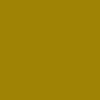

In [9]:
diarrhea = u'#9f8303'
r, g, b = hex_to_rgb(diarrhea)
patch = Image.new("RGB", (100, 100), (int(r),int(g),int(b)))
display(patch)

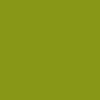

In [10]:
babyshitgreen = u'#889717'
r, g, b = hex_to_rgb(babyshitgreen)
patch = Image.new("RGB", (100, 100), (int(r),int(g),int(b)))
display(patch)

### Load Test Images

To compare XKCD colors to `webcolors` let's load the same test images used by the notebook
[Finding Dominant Color Names from Color Space Coordinates and Images](https://github.com/bakerjd99/smugpyter/blob/master/notebooks/Finding%20Dominant%20Color%20Names%20from%20Color%20Space%20Coordinates%20and%20Images.ipynb).


In [11]:
image1 = Image.open('C:/SmugMirror/Mirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')
image2 = Image.open('C:/SmugMirror/Mirror/Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg')
image3 = Image.open('C:/SmugMirror/Mirror/People/GreatandGreaterForebearers/LX8HmDV-2z-william-evert-baker-portrait-1950.jpg')
image4 = Image.open('C:/SmugMirror/Mirror/Themes/Manipulations/Panoramas/b36sc3H-1-norris-porcelain-basin-yellowstone-panorma.jpg')

(None, 'grassgreen', 30.479501308256342)


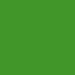

(None, 'darkishpurple', 2.449489742783178)


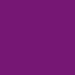

(None, 'lightnavy', 19.261360284258224)


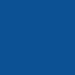

(None, 'brightlilac', 27.129319932501073)


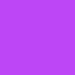

(None, 'robin', 24.73863375370596)


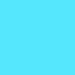

(None, 'camel', 20.223748416156685)


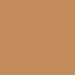

(None, 'yellowishbrown', 7.211102550927978)


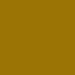

(None, 'lavenderblush', 11.489125293076057)


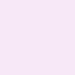

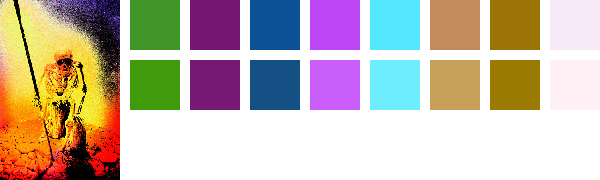

[('grassgreen', 30.479501308256342), ('darkishpurple', 2.449489742783178), ('lightnavy', 19.261360284258224), ('brightlilac', 27.129319932501073), ('robin', 24.73863375370596), ('camel', 20.223748416156685), ('yellowishbrown', 7.211102550927978), ('lavenderblush', 11.489125293076057)]
mean:         17.87278516020819
variance:     86.438550617042
standard dev: 9.297233492660169


In [12]:
def resize_image(image, factor):
    """Resize PIL image maintaining aspect ratio."""
    imcopy = image.copy()
    width, height = imcopy.size
    width = int(factor * width)
    height = int(factor * height) 
    return imcopy.resize((width, height))

def show_xkcd_image_colors(image, colors, *, factor=0.4, patch_size=(50,50), spacing=10):
    """
    Display resized image with adjacent color patches.
    The top patch row shows raw colors and the second
    shows nearest named XKCD colors.
    """
    imnew = resize_image(image, factor)
    # NIMP check that image is 2 * larger than patch size.
    height = imnew.size[1]
    width = imnew.size[0] + (spacing + patch_size[0]) * len(colors)
    background = Image.new('RGBA', (width,height), (255, 255, 255, 255))
    background.paste(imnew, (0,0))
    rgb_distance = []
    xkcd_color = []
    for i, color in enumerate(colors):
        r, g, b = color
        patch1 = Image.new("RGB", patch_size, (int(r),int(g),int(b)))                             
        #patch1 = Image.new("RGB", patch_size, color)
        background.paste(patch1, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), 0))
        _, xkcd_name, rgb_metric = get_xkcd_color_name((int(r),int(g),int(b)))
        xkcd_color.append(xkcd_name)
        rgb_distance.append(rgb_metric)
        # need pixel values for XKCD named colors as PIL images do not support XKCD names
        r, g, b = hex_to_rgb(XKCD_NAMES_TO_HEX.get(xkcd_name))
        patch2 = Image.new("RGB", patch_size, (r,g,b))
        background.paste(patch2, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), spacing + patch_size[1]))
    display(background)
    print([i for i in zip(xkcd_color, rgb_distance)])
    print("mean:         %s" % np.mean(rgb_distance))
    print("variance:     %s" % np.var(rgb_distance))
    print("standard dev: %s" % np.std(rgb_distance))

# random color patches
rcolors0 = []
for a,b in 8 * [(0,255)]:
    rgb0 = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    print(get_xkcd_color_name(rgb0))
    patch = Image.new("RGB", (75, 75), rgb0)
    display(patch)
    rcolors0.append(rgb0)

# patches beside main image  
show_xkcd_image_colors(image2, rcolors0)

### XKCD Dominant Color Calculations 

My primary reason for hacking around with XKCD colors is to find a better
list of colors for assigning dominant image color keys. I use [`SmugPyter`](https://github.com/bakerjd99/smugpyter)
to compute dominant image color keys for my [SmugMug pictures](https://conceptcontrol.smugmug.com/). If you
browse my pictures you will see many keywords like: `0_burlywood`, `0_rosybrown`, `0_gainsboro` and `0_paleturquoise`.
These color keywords are computed by `SmugPyter`. 

`SmugPyter` uses `webcolors` and `webcolors` contains 147 colors. Standard RGB supports sixteen million colors.
Obviously, when you reduce sixteen million choices to 147 there are going to be gaps. The gaps show as 
questionable color shifts from raw RGB to named colors and in the clustering of named colors.

When I computed dominant colors for all my SmugMug images I found:

1. Only 99 of 147 possible colors appear: about 67%.

2. The first six colors are assigned to over 50% of all images.

3. The first color is assigned more often than the last 79 colors.

4. *kmeans* dominant colors are not particularily meaningful for photographs.

Expanding the list of named colors should result in more colors being used.

The following code cell uses this [algorithm from Stack Overflow](https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image) to compute dominant colors.

In [13]:
def array_from_image(image, *, factor=0.4):
    image = resize_image(image, factor)
    ar = np.asarray(image)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    return ar

def calc1_colors(ar, *, num_clusters=8, factor=0.4):
    colors, dist = scipy.cluster.vq.kmeans(ar, num_clusters)
    return colors

def calc1_peak(ar, colors):
    vecs, dist = scipy.cluster.vq.vq(ar, colors)        # assign codes
    counts, bins = scipy.histogram(vecs, len(colors))   # count occurrences
    index_max = scipy.argmax(counts)                    # find most frequent
    peak = colors[index_max]
    return peak

def calc1_colors_peak(image, *, num_clusters=8, factor=0.4):
    ar = array_from_image(image, factor=factor)
    colors = calc1_colors(ar, num_clusters=num_clusters)
    peak = calc1_peak(ar, colors)
    return (colors, peak)
    
NUM_CLUSTERS = 8

calc1_colors1, calc1_peak1 = calc1_colors_peak(image1, num_clusters=NUM_CLUSTERS) 
calc1_colors2, calc1_peak2 = calc1_colors_peak(image2, num_clusters=NUM_CLUSTERS) 
calc1_colors3, calc1_peak3 = calc1_colors_peak(image3, num_clusters=NUM_CLUSTERS) 
calc1_colors4, calc1_peak4 = calc1_colors_peak(image4, num_clusters=NUM_CLUSTERS) 

Applying the dominant color calculation to the test images produces.

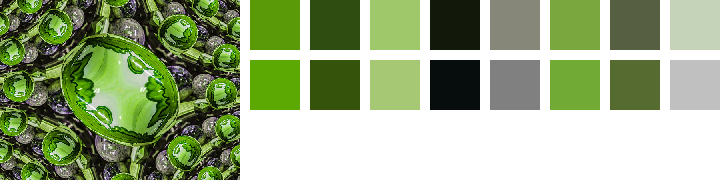

[('leafgreen', 16.401219466856727), ('navygreen', 10.392304845413264), ('lightmossgreen', 12.206555615733702), ('almostblack', 15.84297951775486), ('gray', 11.575836902790225), ('leaf', 14.2828568570857), ('darkolivegreen', 22.561028345356956), ('silver', 22.11334438749598)]
mean:         15.672015742310927
variance:     18.512922572758498
standard dev: 4.302664589851096


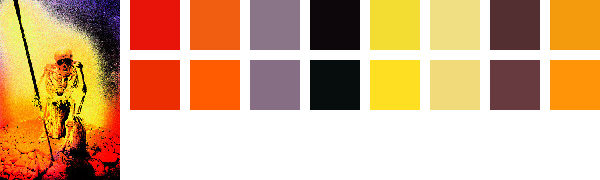

[('tomatored', 26.419689627245813), ('brightorange', 22.22611077089287), ('purplegrey', 7.810249675906654), ('almostblack', 9.695359714832659), ('sunyellow', 20.346989949375804), ('sandy', 10.816653826391969), ('purplebrown', 26.038433132583073), ('tangerine', 13.490737563232042)]
mean:         17.10552803255761
variance:     49.650910727385764
standard dev: 7.046340236419596


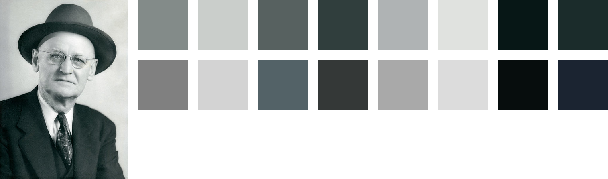

[('gray', 14.52583904633395), ('lightgray', 13.038404810405298), ('gunmetal', 8.12403840463596), ('charcoal', 9.38083151964686), ('darkgray', 16.0312195418814), ('gainsboro', 7.810249675906654), ('almostblack', 13.45362404707371), ('dark', 10.0)]
mean:         11.545525880735479
variance:     8.450832137267252
standard dev: 2.907031499187316


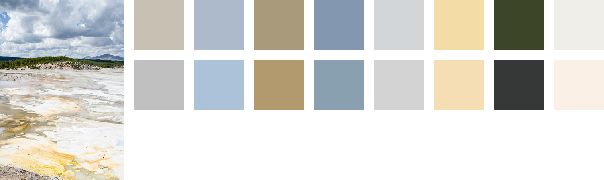

[('silver', 16.1245154965971), ('cloudyblue', 15.264337522473747), ('dust', 15.84297951775486), ('blueygrey', 10.816653826391969), ('lightgray', 5.830951894845301), ('wheat', 12.206555615733702), ('darkgrey', 21.6794833886788), ('linen', 10.63014581273465)]
mean:         13.549452884401266
variance:     19.787326533390218
standard dev: 4.448294789398542


In [14]:
show_xkcd_image_colors(image1, calc1_colors1)   
show_xkcd_image_colors(image2, calc1_colors2)
show_xkcd_image_colors(image3, calc1_colors3)
show_xkcd_image_colors(image4, calc1_colors4)

### More colors reduces mean RGB distance

The mean distance between raw RGB colors and named XKCD colors is lower than the corresponding
mean distance between raw RGB colors and `webcolors`. This is expected. The XKCD colors cover
the RGB space better and you don't need to shift the raw RGB values as much. The longer list
doesn't prevent all bad shifts but it reduces their frequency.

The following J calculations show the difference in RGB space coverage between `webcolors` 
and unified XKCD colors.

In [15]:
# start J assumes jbase.py on Python's search path
j.init() 

In [30]:
# load JOD addon and get smugpyter hacks
j.dor("load 'general/jod'")
j.dor("od ;:'smugpyter utils' [ 3 od '' ")

+-+-----------------+---------+-----+
|1|opened (rw/ro) ->|smugpyter|utils|
+-+-----------------+---------+-----+


In [31]:
# generate and load the XKCDcolors group
j.dor("lg 'XKCDcolors'")
# display short help for group words
j.dor("hg 'XKCDcolors'")

+-+-----------------------+
|1|XKCDcolors group loaded|
+-+-----------------------+
+--------------+-------------------------------------------------------------------------+
|CR            |carriage return character                                                |
|LF            |line feed character                                                      |
|TAB           |tab character                                                            |
|UNIFIED_Colors|color names from merging webcolors, CSS colors and XKCD colors           |
|WEB_PyColors  |Web color table - codes not unique                                       |
|XKCD_Colors   |XKCD color table - names not unique                                      |
|afterstr      |retains string after first occurrence of (x)                             |
|assert        |signal with optional message                                             |
|beforestr     |retains string before first occurrence of (x)                            |
|ctabd

In [32]:
# display web colors coverage verb
# a similar verb computes coverage for XKCD colors
j.dor("disp 'webdist'")

webdist=:3 : 0

NB.*webdist v-- distribute web colors into 64 bins.
NB.
NB. monad: (i[3]Counts ;< btctColors) =. webdist uuIgnore

NB. web color codes are not unique - most of the
NB. code duplicates are spelling variations on grays.
web=. }. WEB_PyColors #~ ~: 2 {"1 WEB_PyColors

NB. encoded rgb - must be unique
ergb=. ; 2 {"1 web
'rgb codes not unique' assert ~: ergb

NB. insert encoded colors in cube
cube=. (>: ergb) (3 {"1 web) } 256 256 256 $ 0

NB. count colors in 64 nonoverlapping bins
pb=. 3 # <256 $ 64 {. 1
dist=. pb ((+/@,)@(0&<));.1 cube

NB. color names in bins
colors=. pb <@(-.&0)@,;.1 cube
colors=. >&.> (<0 {"1 web) {~&.> (<ergb) i.&.> <: L:0 colors

NB. bin counts and color names in bins
dist ; <colors
)


The next calculation inserts the color sets into a `(256 256 256)` RGB color array.
Each array coordinate represents one of the `256^3` possible eight bit RGB colors. The result
is a `(4 4 4)` integer array that counts the number of colors that fall in each `(64 64 64)` 
subarray. The subarrays partition the larger array into sixty-four nonoverlapping bins.

If the named colors are evenly distributed over the RGB cube you would expect the 
`138` unique webcolors to result in about `2.15` colors per cell and the `970` XKCD colors
should be around `15.15.`

In [39]:
print(138 / 64)
print(970 / 64)

2.15625
15.15625


In [37]:
# run webdist , xkcdist and show counts
j.dor("'webcnt wednames'=.webdist 0")
j.dor("'xkcdcnt xkcdnames'=. xkcddist 0")
j.dor("webcnt;xkcdcnt")
j.dor("load 'bstats'")
j.dor("dstat&.> ,&.> webcnt;xkcdcnt")

+--------+-----------+
|1 1 2  2|27  9  7  9|
|1 1 0  0|16 16 20  9|
|2 2 3  2| 8 17  9  5|
|2 1 1  2|10  9  9  9|
|        |           |
|0 0 2  0|16 10  1 11|
|1 1 0  3|28 12 14  8|
|1 0 4  1|19 25 13  3|
|2 0 1  3| 6  8  7  6|
|        |           |
|4 0 2  3|26 12  4  7|
|2 0 0  2|30 20 19  7|
|2 1 4  0|34 18 14  8|
|2 0 2  6|17 12 21 13|
|        |           |
|2 0 2  1|11 13  7  5|
|2 3 2  1|19 25 16 12|
|4 4 3  4|24 17 18 14|
|2 0 6 30|22 26 22 33|
+--------+-----------+
+------------------------+------------------------+
|sample size:          64|sample size:          64|
|minimum:               0|minimum:               1|
|maximum:              30|maximum:              34|
|1st quartile:          0|1st quartile:          8|
|2nd quartile:          2|2nd quartile:         13|
|3rd quartile:          4|3rd quartile:       19.5|
|first mode:            2|first mode:            9|
|first antimode:       30|first antimode:       27|
|mean:             2.1563|mean:            14.406

`webcolors` is not as smoothly distributed as you would like. Many cells have no colors
and one has 30. There are a lot of `webcolor` names for bright colors. XKCD colors cover
all the bins but the count variance is high.

### Basic `SmugPyter` Dominant Color Calculation with XKCD Colors

In [40]:
def dualsort(a, b, *, reverse=False):
        """
        Sort lists (a) and (b) using (a) to grade (b).
        """
        temp = sorted(zip(a, b), key=lambda x: x[0], reverse=reverse)
        return list(map(list, zip(*temp)))
    
def most_common(lst):
        """ Pick most common item in a list - ok for small lists."""
        return max(set(lst), key=lst.count)
    
def cluster_name_freq_dist(image, *, num_clusters=8, factor=0.4):
        """
        Returns a tuple of sorted nearest named colors, cluster frequencies, and
        distances from cluster raw colors. Items are sorted by decreasing
        cluster frequency.
        """
        km = KMeans(n_clusters=num_clusters)
        imcopy = resize_image(image, factor=factor)
        ar = np.asarray(imcopy)
        pixels = ar.reshape((-1, 3))
        km.fit(pixels)
        colors = np.asarray(km.cluster_centers_, dtype=np.uint8)
        frequencies = np.asarray(np.unique(km.labels_, return_counts = True)[1], dtype=np.int32)
        names = []
        distances = []
        for color in colors:
            _ , name , rgb_distance = get_xkcd_color_name(color)
            names.append(name)
            distances.append(rgb_distance)
        # order by decreasing frequency
        _ , names = dualsort(frequencies, names, reverse=True)
        frequencies , distances = dualsort(frequencies, distances, reverse=True)
        return (names, frequencies, distances)
    
def dominant_color_key(names_freqs_dists):
        """
        Return a single dominant color key.
        """
        names , frequencies , distances = names_freqs_dists
       
        if len(names) > len(list(set(names))):
            # most frequent repeated named color
            key = most_common(names)
        else:
            # distances less greatest outlier
            dist_sample = sorted(distances, reverse=True)[1:]
            threshold = np.mean(dist_sample) + np.std(dist_sample)
            
            # default color choice
            key = names[0]
            
            # return first color from sorted names that is no more
            # than one standard deviation from the sample mean. If
            # no such choice is made retain the default selection.
            for name, distance in zip(names, distances): 
                if distance <= threshold:
                    key = name
                    break
                
        return key.lower().strip()
    
names_freq_dist = cluster_name_freq_dist(image1)
print(dominant_color_key(names_freq_dist))

almostblack


In [41]:
# gather unique list of sample image files 
# the same image may occur in many gallery directories
unique_files = set()
unique_full_paths = []
for i, full_path in enumerate(glob.iglob('c:\SmugMirror\Mirror\**\*.jpg', recursive=True)):
    file_name = os.path.basename(full_path)
    if file_name in unique_files:
        #print("duplicate -> %s, %s" % (i,file_name))
        continue
    unique_files.add(file_name)
    unique_full_paths.append(full_path)

In [42]:
print(len(unique_files))
print(len(unique_full_paths))

3863
3863


### Compute XKCD color for all SmugMug sample images

The next cell computes the dominant color for all my SmugMug sample images. There are
are about 4000 images. This calculation takes over an hour on my machine. 

In [43]:
# collect sample of XKCD dominant colors
rows = []
file_count = len(unique_full_paths)
for i, file_name in enumerate(unique_full_paths):
    image = Image.open(file_name)
    names_freq_dist = cluster_name_freq_dist(image)
    xkcd_color = dominant_color_key(names_freq_dist)
    color_info = {'XKCDColor': xkcd_color, 'SampleFile': os.path.basename(file_name)}
    rows.append(color_info)
    # every n rows print message
    if 0 == (i % 20):
        print("%s/%s %s - %s" % (i + 1, file_count, xkcd_color, os.path.basename(file_name)))

# write TAB delimited file    
sample_file = "c:/temp/xkcd_dominant.txt"
keys = rows[0].keys()
with open(sample_file, 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys, dialect='excel-tab')
    dict_writer.writeheader()
    dict_writer.writerows(rows)

1/3863 browngrey - 2BCNG5j-1o-IMG_0029.JPG
21/3863 black - 2FVN936-1k-anathem.jpg
41/3863 palegrey - FBkwG7D-2t-isabelle_intro.jpg
61/3863 black - PnM2XvX-2d-prometheus_movie.jpg
81/3863 snow - VTHCgxD-3d-HeadUpAssLogo.jpg
101/3863 lightblue - 5ZJ6wn3-1c-hazel-august-1944-[350452336].jpg
121/3863 whitesmoke - f2CGP9Z-t-evelyn-and-baby-alberta-[2243036].jpg
141/3863 charcoalgrey - JTzgkRd-2q-gert-alberta-ginger.jpg
161/3863 mushroom - qnbPWV6-e-steve-me-mom-salt-lake-1962-[129897838].jpg
181/3863 purplishbrown - vDrCnGP-17-judy-porch-1950.jpg
201/3863 lightgreyblue - 4sXbrtb-g-grandpa-baker-golf-cart-1971-5x7-[70246107].jpg
221/3863 linen - QpcNnPP-23-gert-by-mailbox-1969-[178135514].jpg
241/3863 linen - jq54JDC-7-eliza-jane-gilbert-b1840-d1915.jpg
261/3863 fadedblue - Sf496Ps-1u-santa-luisa-ship-1962.jpg
281/3863 lightsteelblue - BMTKWnW-3h-maryam-sandia-crest-trail.jpg
301/3863 pinkishgrey - Jq8x6wH-1t-mahin-mali-90th-birthday.jpg
321/3863 warmgrey - VGrqMgX-2t-maurice-dubin-[74167793

2581/3863 charcoalgrey - n3nHSX6-e-iphone-7816406.jpg
2601/3863 pinkishgrey - xbXQVh2-s-iphone-5393643.jpg
2621/3863 lavender - NxzHm4B-21-office-cubicle.jpg
2641/3863 mistyrose - fRHrmJM-1f-me-nude-16-town-garden-drive-liverpool-august-1992.jpg
2661/3863 coolgrey - SB9HpHV-2z-me-boise-art-museum-frame.jpg
2681/3863 black - 7TBGsRv-1m-vine-shine-[2773479402].jpg
2701/3863 cocoa - H7Wr2tv-28-eye-of-color-storm.jpg
2721/3863 oldlace - qssv867-0-mirror-head.jpg
2741/3863 palegrey - z5HK7PX-r-my-cameras-over-time-[412898230].jpg
2761/3863 pinkishgrey - dFVXsHC-1n-painted-hills-overlook-panorama.jpg
2781/3863 dark - zQsCSz5-18-portland-willamette-river-panorama.jpg
2801/3863 mediumgrey - dtcM4LC-b-aunt-maud-before-after-1902.jpg
2821/3863 mediumgrey - PjRFVwc-2k-before-after-davis-sisters-mother-1906.jpg
2841/3863 warmgrey - XTh2xVg-2q-minnie-brother-twentyseven-1916-before-after.jpg
2861/3863 charcoal - 2QVqgrn-1c-offscale-[318295313].jpg
2881/3863 black - f9jNBvp-c-bone-face-carving-[7342

### Frequencies of computed colors

Applying the following J verb to the file computed in the previous cell.

In [44]:
j.dor('xkcdcolorfreq')

3 : 0

NB.*xkcdcolorfreq v-- XKCD color key frequencies from TAB delimited file.
NB.
NB. monad:  xkcdcolorfreq clXKCDfile
NB.
NB.   xkcdcolorfreq 'c:/temp/xkcd_dominant.txt'

d=. readtd2 y
'k f'=. ofreq s: 0 {"1 }. d
c=. 100 * +/\ f % +/ f

NB. frequency summary
s=. ,.&.> (>: i. #k);k;f;(100 * f % +/f);c;+/\. f
(<;._1 ';count;color key;frequency;percent;cummulative;reverse') ,: s
)


In [47]:
j.dor("cf=. xkcdcolorfreq 'c:/temp/xkcd_dominant.txt'")
j.dor("(0{cf) ,: 30 {.&.> 1{cf")

+-----+--------------+---------+----------+-----------+-------+
|count|color key     |frequency|percent   |cummulative|reverse|
+-----+--------------+---------+----------+-----------+-------+
| 1   |`almostblack  |459      | 11.881957|11.881957  |3863   |
| 2   |`silver       |170      | 4.4007248|16.282682  |3404   |
| 3   |`black        |140      | 3.6241263|19.906808  |3234   |
| 4   |`gainsboro    |139      | 3.5982397|23.505048  |3094   |
| 5   |`lightgray    |132      | 3.4170334|26.922081  |2955   |
| 6   |`lavender     | 99      |  2.562775|29.484856  |2823   |
| 7   |`darkgray     | 94      |  2.433342|31.918198  |2724   |
| 8   |`charcoalgrey | 92      | 2.3815687|34.299767  |2630   |
| 9   |`darkgrey     | 88      | 2.2780223|36.577789  |2538   |
|10   |`charcoal     | 82      | 2.1227026|38.700492  |2450   |
|11   |`lightgreyblue| 76      | 1.9673829|40.667875  |2368   |
|12   |`warmgrey     | 74      | 1.9156096|42.583484  |2292   |
|13   |`whitesmoke   | 67      | 1.73440

### Final Remarks

Increasing the number of named colors does not significantly improve
the quality of dominant color selection. The main effect is to 
increase the number of grays and near grays. This is not unexpected. There
is a reason that photographs have been calibrated against [gray cards](https://en.wikipedia.org/wiki/Gray_card) for 
almost a century. If you average out all the colors in typical scenes
in well exposed pictures you usually end up with a neutral tone or gray.
Here the top ten dominant colors are mostly gray. 

almostblack


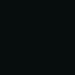

silver


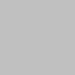

black


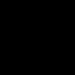

gainsboro


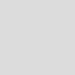

lightgray


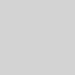

lavender


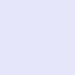

darkgray


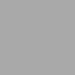

charcoalgrey


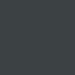

darkgrey


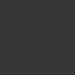

charcoal


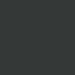

In [56]:
topten = ['almostblack','silver','black','gainsboro','lightgray','lavender',
           'darkgray','charcoalgrey','darkgrey','charcoal'] 

for color in topten:
    r, g, b = hex_to_rgb(XKCD_NAMES_TO_HEX.get(color))
    print(color)
    patch = Image.new("RGB", (75, 75), (int(r),int(g),int(b)))
    display(patch)